In [1]:
import pandas
import numpy as np
from datetime import datetime

In [2]:
df = pandas.read_csv("fake_membership_list_20240102.csv",
                     usecols=["join_date", "xdate"],
                     converters={
                         "join_date": pandas.to_datetime,
                         "xdate": pandas.to_datetime,
                     })
df.columns = ['join', 'expire']
df['count'] = 1
df = df[df['expire'] < '2099-01-01'] # filter out all lifetime members
df['join_year'] = pandas.PeriodIndex(df['join'], freq='Y').to_timestamp()
df['join_quarter'] = pandas.PeriodIndex(df['join'], freq='Q').to_timestamp()
# :KLUDGE: ONLY WORKS AT THE BEGINNING OF 2024
# Jank trick to "round" all current members to a full year of membership
df['expire_trunc'] = pandas.DataFrame([df['expire'], df['join'].apply(lambda x: datetime(2024, x.month, x.day))]).min()
df['age_years'] = (df['expire_trunc'].dt.to_period('Y') - df['join'].dt.to_period('Y')).apply(lambda x: x.n)
df['age_months'] = (df['expire_trunc'].dt.to_period('M') - df['join'].dt.to_period('M')).apply(lambda x: x.n)
df

,join,expire,count,join_year,join_quarter,expire_trunc,age_years,age_months
0,2021-08-09,2024-08-27,1,2021-01-01,2021-07-01,2024-08-09,3,36
1,2021-04-13,2023-01-22,1,2021-01-01,2021-04-01,2023-01-22,2,21
2,2021-09-27,2022-12-16,1,2021-01-01,2021-07-01,2022-12-16,1,15
3,2017-09-20,2019-02-26,1,2017-01-01,2017-07-01,2019-02-26,2,17
4,2020-08-28,2023-02-01,1,2020-01-01,2020-07-01,2023-02-01,3,30
...,...,...,...,...,...,...,...,...
1995,2017-04-23,2020-05-01,1,2017-01-01,2017-04-01,2020-05-01,3,37
1996,2017-09-25,2024-10-23,1,2017-01-01,2017-07-01,2024-09-25,7,84
1997,2020-12-14,2022-08-04,1,2020-01-01,2020-10-01,2022-08-04,2,20
1998,2022-03-29,2023-03-29,1,2022-01-01,2022-01-01,2023-03-29,1,12


In [3]:
retention_year = df.pivot_table(index=['join_year'], columns=['age_years'], values='count', fill_value=0,
                                aggfunc="sum").transpose()[::-1].cumsum()[::-1].transpose().replace(to_replace=0,
                                                                                                    value=np.NAN)
retention_year

age_years,1,2,3,4,5,6,7,8
join_year,,,,,,,,
2016-01-01,259,201.0,121.0,103.0,83.0,65.0,41.0,25.0
2017-01-01,248,180.0,112.0,86.0,67.0,47.0,27.0,NaN
2018-01-01,236,178.0,111.0,87.0,64.0,30.0,NaN,NaN
2019-01-01,255,183.0,102.0,69.0,33.0,NaN,NaN,NaN
2020-01-01,229,177.0,92.0,53.0,NaN,NaN,NaN,NaN
2021-01-01,243,178.0,79.0,NaN,NaN,NaN,NaN,NaN
2022-01-01,265,193.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
a = df.pivot_table(index=['join_year'], columns=['age_years'], values='count', fill_value=0, aggfunc="sum").transpose()[
    ::-1]
retention_pct_year = (a.cumsum() / a.sum())[::-1].transpose().replace(to_replace=0, value=np.NAN)
retention_pct_year

age_years,1,2,3,4,5,6,7,8
join_year,,,,,,,,
2016-01-01,1.0,0.776062,0.467181,0.397683,0.320463,0.250965,0.158301,0.096525
2017-01-01,1.0,0.725806,0.451613,0.346774,0.270161,0.189516,0.108871,NaN
2018-01-01,1.0,0.754237,0.470339,0.368644,0.271186,0.127119,NaN,NaN
2019-01-01,1.0,0.717647,0.400000,0.270588,0.129412,NaN,NaN,NaN
2020-01-01,1.0,0.772926,0.401747,0.231441,NaN,NaN,NaN,NaN
2021-01-01,1.0,0.732510,0.325103,NaN,NaN,NaN,NaN,NaN
2022-01-01,1.0,0.728302,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
retention_year_mos = df.pivot_table(index=['join_year'], columns=['age_months'], values='count', fill_value=0, aggfunc="sum").transpose()[::-1].cumsum()[::-1].transpose().replace(to_replace=0, value=np.NAN)
a = df.pivot_table(index=['join_year'], columns=['age_months'], values='count', fill_value=0,
                   aggfunc="sum").transpose()[
    ::-1]
retention_pct_yr_mos = (a.cumsum() / a.sum())[::-1].transpose().replace(to_replace=0, value=np.NAN)
retention_pct_yr_mos

age_months,12,13,14,15,16,17,18,19,20,21,...,85,87,88,89,90,91,92,94,95,96
join_year,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.0,0.984556,0.942085,0.891892,0.861004,0.837838,0.806950,0.768340,0.741313,0.694981,...,0.127413,0.123552,0.119691,0.104247,0.092664,0.084942,0.069498,0.065637,0.057915,0.054054
2017-01-01,1.0,0.971774,0.943548,0.899194,0.850806,0.802419,0.750000,0.689516,0.637097,0.600806,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.978814,0.944915,0.915254,0.847458,0.792373,0.745763,0.720339,0.682203,0.631356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01,1.0,0.984314,0.972549,0.917647,0.870588,0.843137,0.792157,0.741176,0.678431,0.627451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,1.0,0.982533,0.956332,0.921397,0.886463,0.842795,0.799127,0.777293,0.711790,0.646288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01,1.0,0.971193,0.909465,0.864198,0.823045,0.790123,0.769547,0.716049,0.679012,0.617284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01,1.0,0.966038,0.920755,0.860377,0.818868,0.769811,0.739623,0.705660,0.649057,0.622642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

/var/folders/1n/_8ll6s1n7cb07nfp_wzl1f6h0000gn/T/ipykernel_65622/1921748700.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


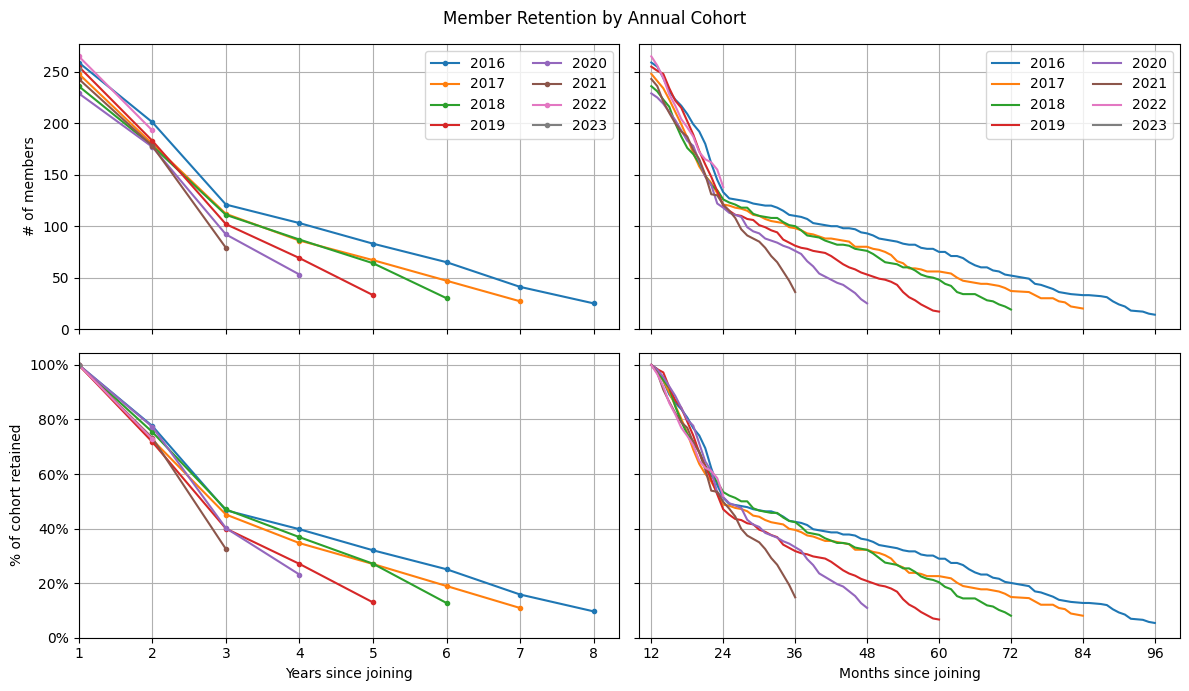

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(12,7))
fig.suptitle("Member Retention by Annual Cohort")

ax[0][0].plot(retention_year.transpose(), marker='.')
ax[0][0].grid(visible=True)
ax[0][0].set_xlim(1)
ax[0][0].set_ylim(0)
ax[0][0].legend([d.year for d in retention_year.index], loc='upper right', ncols=2)
ax[0][0].set_ylabel("# of members")

ax[1][0].plot(retention_pct_year.transpose(), marker='.')
ax[1][0].grid(visible=True)
ax[1][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1][0].set_ylim(0)
ax[1][0].set_xlabel("Years since joining")
ax[1][0].set_ylabel("% of cohort retained")

ax[0][1].plot(retention_year_mos.transpose(), marker='')
ax[0][1].grid(visible=True)
ax[0][1].set_xlim(10)
ax[0][1].xaxis.set_major_locator(mtick.MultipleLocator(12, 12))
ax[0][1].set_ylim(0)
ax[0][1].legend([d.year for d in retention_year_mos.index], loc='upper right', ncols=2)

ax[1][1].plot(retention_pct_yr_mos.transpose(), marker='')
ax[1][1].grid(visible=True)
ax[1][1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1][1].set_ylim(0)
ax[1][1].set_xlabel("Months since joining")

fig.tight_layout()

fig.show()

In [8]:
a = df.pivot_table(index=['join_quarter'], columns=['age_years'], values='count', fill_value=0,
                   aggfunc="sum").transpose()[
    ::-1]
retention_pct_year_quarter = (a.cumsum() / a.sum())[::-1].transpose().replace(to_replace=0, value=np.NAN).interpolate(
    limit=1, limit_area='inside')
retention_pct_year_quarter

age_years,1,2,3,4,5,6,7,8
join_quarter,,,,,,,,
2016-01-01,1.0,0.585714,0.414286,0.357143,0.328571,0.228571,0.171429,0.085714
2016-04-01,1.0,0.790323,0.467742,0.419355,0.322581,0.258065,0.161290,0.080645
2016-07-01,1.0,0.803279,0.409836,0.311475,0.245902,0.196721,0.131148,0.114754
2016-10-01,1.0,0.939394,0.575758,0.500000,0.378788,0.318182,0.166667,0.106061
2017-01-01,1.0,0.561404,0.456140,0.403509,0.350877,0.298246,0.192982,NaN
2017-04-01,1.0,0.615385,0.415385,0.292308,0.184615,0.123077,0.061538,NaN
2017-07-01,1.0,0.808219,0.452055,0.315068,0.219178,0.123288,0.082192,NaN
2017-10-01,1.0,0.924528,0.490566,0.396226,0.358491,0.245283,0.113208,NaN
2018-01-01,1.0,0.607843,0.450980,0.411765,0.352941,0.196078,NaN,NaN


/var/folders/1n/_8ll6s1n7cb07nfp_wzl1f6h0000gn/T/ipykernel_65622/2158181012.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


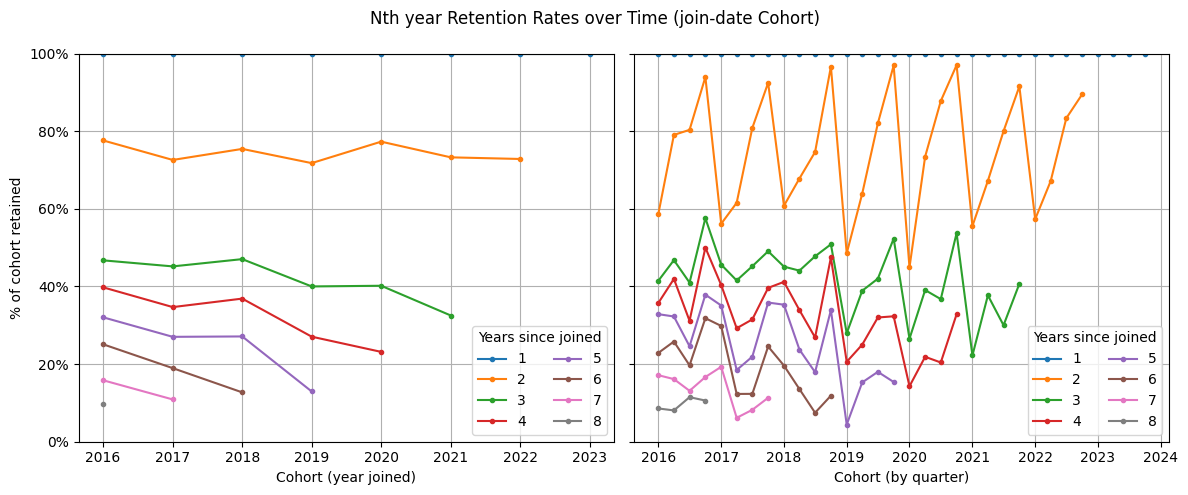

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
fig.suptitle("Nth year Retention Rates over Time (join-date Cohort)")
ax[0].plot(retention_pct_year, marker='.')
ax[0].grid(visible=True)
ax[0].set_ylim(0, 1)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].set_xlabel("Cohort (year joined)")
ax[0].set_ylabel("% of cohort retained")
ax[0].legend([c for c in retention_pct_year.columns], loc='lower right', ncols=2, title='Years since joined')

ax[1].plot(retention_pct_year_quarter, marker='.')
ax[1].grid(visible=True)
ax[1].set_ylim(0)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].set_xlabel("Cohort (by quarter)")
ax[1].legend([c for c in retention_pct_year_quarter.columns], loc='lower right', ncols=2,
             title='Years since joined')

fig.tight_layout()
fig.show()


/var/folders/1n/_8ll6s1n7cb07nfp_wzl1f6h0000gn/T/ipykernel_65622/629615459.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


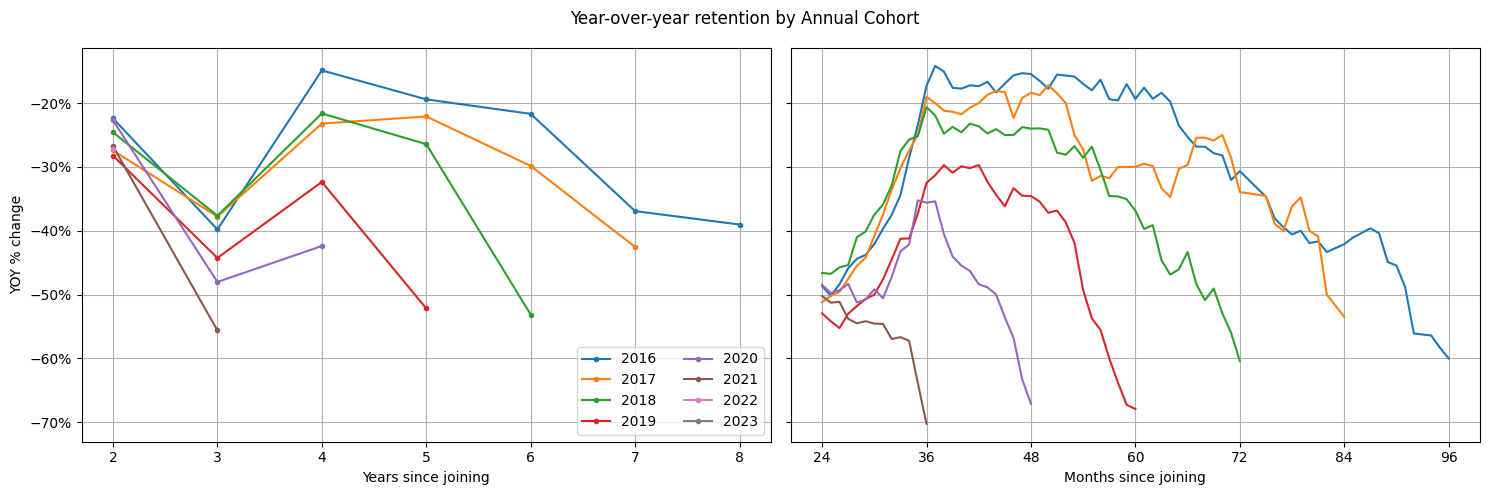

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
fig.suptitle("Year-over-year retention by Annual Cohort")
ax[0].plot(retention_year.transpose().pct_change(fill_method=None), marker='.')
ax[0].grid(visible=True)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].set_xlabel("Years since joining")
ax[0].set_ylabel("YOY % change")
ax[0].legend([d.year for d in retention_year.index], loc='lower right', ncols=2)

ax[1].plot(retention_pct_yr_mos.transpose().pct_change(periods=12, fill_method=None), marker='')
ax[1].grid(visible=True)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[1].set_xlabel("Months since joining")
ax[1].xaxis.set_major_locator(mtick.MultipleLocator(12, 12))

fig.tight_layout()
fig.show()

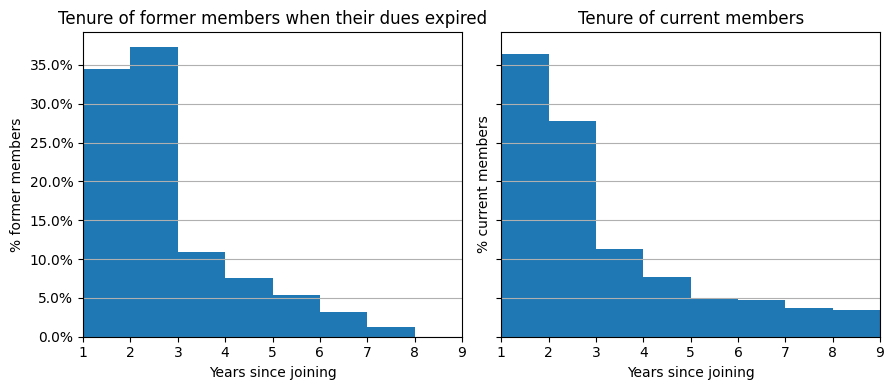

In [11]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].set_title("Tenure of former members when their dues expired")
ax[0].hist(df[df['expire'] < '2023-12-01']['age_years'], bins=range(1,10), density=True, align='mid')
ax[0].set(xlim=(1, 9))
ax[0].set_xlabel("Years since joining")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax[0].set_ylabel("% former members")
ax[0].grid(axis='y')

ax[1].set_title("Tenure of current members")
ax[1].hist(df[df['expire'] >= '2023-12-01']['age_years'], bins=range(1,10), density=True, align='mid')
ax[1].set_xlabel("Years since joining")
ax[1].set_ylabel("% current members")
ax[1].grid(axis='y')

fig.tight_layout()
plt.show()